# Chapter 16   
***  
## Natural Language Processing with RNNs and Attention  
***  


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

In [21]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


***  
## “The Unreasonable Effectiveness of Recurrent Neural Networks,”
2015 https://karpathy.github.io/2015/05/21/rnn-effectiveness/  
***  
showed how to train an RNN to predict the next character in a sentence. This Char-RNN

# Char-RNN

## Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


# Creating the Training Dataset  
***
## Loading the Data and Preparing the Dataset  
***  


In [23]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [24]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [25]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

### Next, we must encode every character as an `integer`  
 - One option is to create a custom preprocessing layer,  
 - simpler to use Keras’s Tokenizer class  
  - <font color=pink>char_level=True</font> to get `character-level encoding` rather than the default word-level encoding

In [26]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
# char_level=True -> character-level encoding
tokenizer.fit_on_texts(shakespeare_text)

In [27]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [28]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [29]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [30]:
max_id, dataset_size

(39, 1115394)

### encode the full text so each character is represented by its ID  
*** 

In [31]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
# texts_to_sequences  
# subtract 1 to get IDs from 0 to 38, rather than from 1 to 39
# why???????????? -1??????????????????????????????????????????????????????

In [32]:
encoded.shape, [encoded]

((1115394,), [array([19,  5,  8, ..., 20, 26, 10])])

### How to Split a Sequential Dataset   
*** 
need to split the dataset into a training set, a validation set, and a test set.  
can’t just shuffle all the characters in the text,

####  financial health of 10,000 companies 
for example, if you have data about the financial health of 10,000 companies from 2000 to 2018,   
 - you might be able to split this data across the different companies.   
 - It’s very likely that many of these companies will be strongly correlated, though (e.g., whole economic sectors may go up or down jointly  

test set will not be as useful, as its measure of the generalization error will be optimistically biased.

So, it is often safer to split across time   
 - we assume that the time series is stationary
  -  stationary time series’s `mean, variance, and autocorrelations` (i.e., correlations between values in the time series separated by a given interval) do not change over time.

In [33]:
train_size = dataset_size * 90 // 100
# first 90% of the text for the training set

dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
# tf.data.Dataset that will return each character one by one from this set

In [34]:
[encoded], train_size, type(dataset), dataset

([array([19,  5,  8, ..., 20, 26, 10])],
 1003854,
 tensorflow.python.data.ops.dataset_ops.TensorSliceDataset,
 <TensorSliceDataset shapes: (), types: tf.int64>)

### Chopping the Sequential Dataset into Multiple Windows  
dataset’s window() method to convert this long sequence of characters into many smaller windows of text.   
 - <font color=pink>window()</font> method creates a dataset that contains windows, each of which is also represented as a dataset. It’s a `nested dataset`, analogous to a list of lists  
 - <font color=pink>flat_map()</font> method: it converts a nested dataset into a `flat dataset`.  
  - If you flatten the nested dataset `{{1, 2}, {3, 4, 5, 6}}`, you get back the flat dataset `{1, 2, 3, 4, 5, 6}`  
 - <font color=pink>lambda ds: ds.batch(2)</font> to flat_map(), then it will transform the nested dataset {{1, 2}, {3, 4, 5, 6}} into the flat dataset {[1, 2], [3, 4], [5, 6]}

In [35]:
n_steps = 100
# RNN will not be able to learn any pattern longer than n_steps, so don’t make it too small.

window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)  
# dataset’s window() method
# to convert this long sequence of characters into many smaller windows of text. 

# shift=1  
# To get the largest possible training set 
# first window contains characters 0 to 100, 
# the second contains characters 1 to 101, and so on  

# drop_remainder=True

In [36]:
dataset

<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorShape([]))>

In [37]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))
# Now the dataset contains consecutive windows of 101 characters each

In [38]:
window_length

101

In [39]:
dataset

<FlatMapDataset shapes: (None,), types: tf.int64>

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

In [41]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

Windows of length 11 rather than 101,   
batch size of 3 instead of 32  
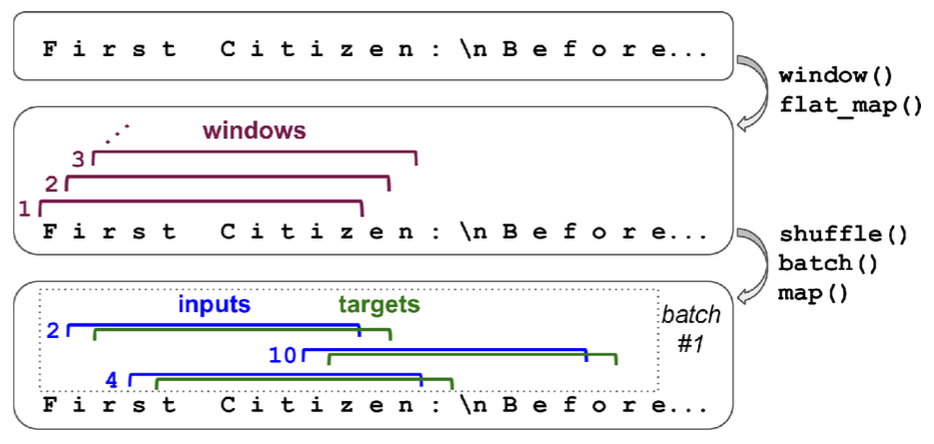

In [42]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))  
    # will encode each character using a one-hot vector because there are fairly few distinct characters (only 39):

In [43]:
dataset = dataset.prefetch(1)
# need to add prefetching??? why??

In [49]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model  
***  
To predict the next character based on the previous 100 characters,  


In [45]:
# Importing PlaidML. Make sure you follow this order
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [ ]:
# very long rime
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    # RNN with 2 GRU layers of 128 units each and 20% dropout on both the inputs(drop out) 
    # and the hidden states (recurrent_dropout)
    # This layer must have 39 units (max_id)
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
    # The output probabilities should sum up to 1 at each time step, 
    # so we apply the softmax activation function
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=1)

  139/31370 [..............................] - ETA: 3:30:17 - loss: 2.8418

## Using the Model to Generate Text
***
### Using the Char-RNN Model     
***  
model that can predict the next character in text written by Shakespeare

In [65]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [20]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [21]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]])

## Generating Fake Shakespearean Text  
***  
we can pick the next character randomly, with a probability equal to the estimated probability, using TensorFlow’s <font color=pink>tf.random.categorical()</font> function.  
 - categorical() function samples random class indi‐ ces, given the class log probabilities (logits)
 - a temperature close to 0 will favor the highprobability characters  

<br>  
 - could try using `more GRU layers` and `more neurons per layer`, `train for longer`, and add some `regularization` (for example, you could set recur rent_dropout=0.3 in the GRU layers)  
 - Moreover, the model is currently incapable of learning patterns longer than `n_steps`, which is just 100 characters

### next_char() function   
uses temperature, approach to pick the next character to add to the input text

In [62]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [23]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

### complete_text() function   
that will repeatedly call <font color=pink>next_char()</font> to get the next character and append it to the given text:

In [63]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
        # repeatedly call next_char()
    return text

In [25]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

# the belly the charges of the other words and belly 

the belly the charges of the other words
and belly 


In [26]:
print(complete_text("t", temperature=1))
# Shakespeare model works best at a temperature close to 1

thing! they know't.

biondello:
for you are the own


In [27]:
print(complete_text("t", temperature=2))

th no cyty
use ffor was firive this toighingaber; b


## Stateful RNN  
***  
Until now, we have used only _`stateless RNNs`_  
 - each training iteration the model starts with a hidden state full of zeros,   
 - then it updates this state at each time step,   
 - and after the last time step, it throws it away  

_`stateful RNN`_  
 - RNN to `preserve this final state` after processing one training batch   
 - and use it as the initial state for the next training batch?   
 - This way the model can learn `long-term patterns` despite only backpropagating through short sequences  
1. need to do to build a stateful RNN is to use sequential and nonoverlapping input sequences  
2. When creating the Dataset, we must therefore use <font color=pink>shift=n_steps</font> (instead of shift=1)  
3. obviously `not call` the <font color=pink>shuffle()</font> method.  
4. batching is `much harder` when preparing a dataset for a stateful RNN  
The first batch would contain windows 1 to 32 and the second batch would contain windows 33 to 64.  
`simplest solution` to this problem is to just use `“batches” containing a single window`: 

summarizes the first steps. 
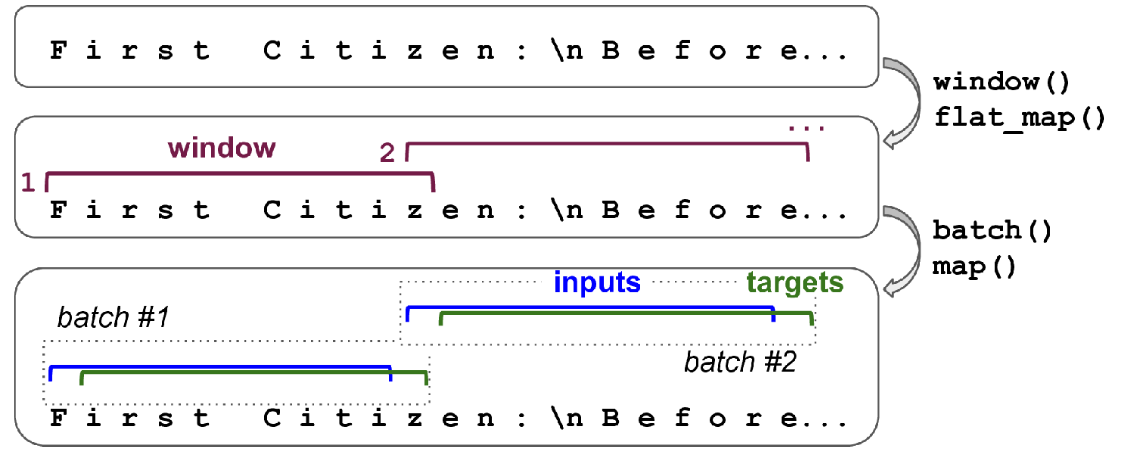

In [51]:
tf.random.set_seed(42)

In [53]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
# shift=n_steps (instead of shift=1)

dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)

dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [54]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
    # could chop Shakespeare’s text into 32 texts of equal length, 
    # create one dataset of consecutive input sequences for each of them
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
# To create proper consecutive batches, where the n(th) input sequence in a batch 
# starts off exactly where the n(th) input sequence ended in the previous batch.

dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [55]:
# stateful RNN
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    # must set the batch_input_shape argument in the first layer. 
    # can leave the second dimension unspecified, since the inputs could have any length
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2),
    # First, we need to set stateful=True  
    
    # Second, the stateful RNN needs to know the batch size  
  
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [56]:
# At the end of each epoch, we need to reset the states before we go back to the beginning of the text
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [57]:
# each epoch is much shorter than earlier, and there is only one instance per batch
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 104s 333ms/step - loss: 2.6148
Epoch 2/50
313/313 [==============================] - 102s 326ms/step - loss: 2.2083
Epoch 3/50
313/313 [==============================] - 103s 328ms/step - loss: 2.0654
Epoch 4/50
313/313 [==============================] - 103s 330ms/step - loss: 1.9779
Epoch 5/50
313/313 [==============================] - 101s 321ms/step - loss: 1.9185
Epoch 6/50
313/313 [==============================] - 89s 285ms/step - loss: 1.8766
Epoch 7/50
313/313 [==============================] - 109s 347ms/step - loss: 1.8437
Epoch 8/50
313/313 [==============================] - 102s 327ms/step - loss: 1.8186
Epoch 9/50
313/313 [==============================] - 89s 285ms/step - loss: 1.7988
Epoch 10/50
313/313 [==============================] - 109s 347ms/step - loss: 1.7810
Epoch 11/50
313/313 [==============================] - 104s 332ms/step - loss: 1.7657
Epoch 12/50
313/313 [==============================] - 110s 350ms

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

In [58]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [59]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [60]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [66]:
# 4.3.1 function()
# 4.4.1 function()
# 4.4.2 function()
tf.random.set_seed(42)

print(complete_text("t"))

# tor: in the loving last but a way law not, buciness

tor:
in the loving last but a way law not,
buciness


# Sentiment Analysis  
***  
 - IMDb reviews dataset is the “hello world” of natural language processing  
 - along with a simple binary target for each review indicating whether it is negative (0) or positive (1)

In [67]:
tf.random.set_seed(42)

## You can load the IMDB dataset easily:

In [72]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

 - All punctuation was removed, and then words were converted to lowercase, split by spaces, and finally indexed by frequency.  
 - The integers are special:  
  - 0 : padding token
  - 1 : the start-of-sequence (SSS) token
  - 2 : and unknown words  
***  
2018 https://arxiv.org/abs/1804.10959   
unsupervised learning technique to tokenize and detokenize text at the subword level in a language-independent way, `treating spaces like other characters`.
***  
2018 https://arxiv.org/abs/1808.06226
Google’s SentencePiece project provides an open source implementation,  
***  
2016 https://arxiv.org/abs/1508.07909
explored other ways of creating subword encodings (e.g., using byte pair encoding)  
***  
TF.Text library in June 2019 https://medium.com/tensorflow/introducing-tf-text-438c8552bd5e which implements various tokenization strategies, including  
2016 https://arxiv.org/abs/1609.08144  (a variant of byte pair encoding). 
***  
If you want to deploy your model to a mobile device or a web browser  
 -  then you will want to handle preprocessing using only TensorFlow operations, so it can be included in the model itself.

In [69]:
# X_train consists of a list of reviews,
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

 ### to visualize a review, you can decode it like this:

In [70]:
# to visualize a review, you can decode it like this:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

####  load the original IMDb reviews, as text (byte strings), using TensorFlow Datasets 

In [73]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Shuffling and writing examples to /Users/j/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX31LHW/imdb_reviews-train.tfrecord


Shuffling and writing examples to /Users/j/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX31LHW/imdb_reviews-test.tfrecord


Shuffling and writing examples to /Users/j/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX31LHW/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /Users/j/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [74]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [75]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [76]:
train_size, test_size

(25000, 25000)

In [77]:
# ?
for X_batch, y_batch in datasets["train"].batch(2).take(1):
# 배치 2개씩 테이크 1????
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [100]:
print("Review:", review.decode("utf-8")[:202])
print("Label:", label, "= Positive" if label else "= Negative")
print('X_batch', X_batch.numpy(), len(X_batch),'\n') 
print('y_batch', y_batch.numpy())
print(zip(X_batch.numpy(), y_batch.numpy()))

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on
Label: 0 = Negative
X_batch [b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during film

###  preprocess() function

In [96]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    # starts by truncating the reviews, keeping only the first 300 characters of each
    # -> will speed up training
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    # uses regular expressions to replace <br /> tags with spaces, 
    
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    # replace any characters other than letters and quotes with spaces
    #  "Well, I can't<br />" --> "Well I can't"
    
    X_batch = tf.strings.split(X_batch)
    # splits the reviews by the spaces, which returns a ragged tensor,
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch
    # and it converts this ragged tensor to a dense tensor, 
    # padding all reviews with the padding token "<pad>" so that they all have the same length.

In [48]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

### Counter to count the number of occurrences of each word:

In [101]:
# need to construct the vocabulary
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

### most_common():  most common words 

In [102]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [103]:
len(vocabulary)

53893

###  truncate the vocabulary, keeping only the 10,000 most common words:

In [104]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [105]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


###  add a preprocessing step to replace each word with its ID  
 create a lookup table for this, using 1,000 out-of-vocabulary (oov) buckets:

In [106]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

###  use this table to look up the IDs of a few words  
 - “this,” “movie,” and “was” were found in the table, so their IDs are `lower than 10,000`,  
 - while the word “faaaaaantastic” was not found, so it was `mapped to one of the oov buckets` `ID greater than or equal to 10,000`.  

###  tft.compute_and_apply_vocabulary() function:  
 - it will go through the dataset to find all distinct words and build the vocabulary, and it will generate the TF operations required to encode each word using this vocabulary.

In [107]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

###  encode_words() function   
encode these words using a simple function that uses the table we just built, and finally prefetch the next batch:

In [108]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [109]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


### model and train it:  
 - first layer is an Embedding layer, which will convert word IDs into embeddings (introduced in Chapter 13)  
  - embedding matrix needs to have one row per word ID (vocab_size + num_oov_buckets)   
  - and one column per embedding dimension (this example uses 128 dimensions)   
  -  inputs of the model will be `2D tensors` of shape `[batch size, time steps]`, the output of the Embedding layer will be a `3D tensor` of shape `[batch size, time steps, embedding size]`.  
 - two GRU layers, with the second one returning only the output of the last time step. 

In [110]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, 
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    #  Embedding layer, convert word IDs into embeddings
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 141s 181ms/step - loss: 0.5305 - accuracy: 0.7282
Epoch 2/5
781/781 [==============================] - 141s 181ms/step - loss: 0.3459 - accuracy: 0.8554
Epoch 3/5
781/781 [==============================] - 150s 192ms/step - loss: 0.1913 - accuracy: 0.9319
Epoch 4/5
781/781 [==============================] - 126s 161ms/step - loss: 0.1341 - accuracy: 0.9535
Epoch 5/5
781/781 [==============================] - 125s 160ms/step - loss: 0.1011 - accuracy: 0.9624


### Masking
Or using manual masking:  
 - model will need to learn that the `padding tokens should be ignored`.  
 - add <font color=pink>mask_zero=True</font> when creating the Embedding layer.  
  -  padding tokens will be ignored by all downstream layers.  
 - All layers that receive the mask must support masking (or else an exception will be raised)  
  - includes all `recurrent layers`, as well as the `TimeDistributed layer` and a `other layers`.  
  - Any layer that supports masking must have a <font color=pink>supports_masking</font> attribute equal to <font color=pink>True</font>.  
  - If your layer does not start with an Embedding layer, you may use the <font color=pink>keras.layers.Masking</font> layer instead.  
    - it sets the mask to  <font color=pink>K.any(K.not_equal(inputs, 0), axis=-1)</font>.  
    - meaning that time steps where the `last dimension` is `full of zeros will be masked out in subsequent layers` (again, as long as the time dimension exists).
  
Using masking layers and automatic mask propagation works `best for simple Sequential models`.   
It will `not always work for more complex models`,   
 - such as when you need to mix Conv1D layers with recurrent layers.  
  -  In such cases, you will need to explicitly compute the mask and pass it to the appropriate layers, using either the `Functional API` or the `Subclassing API`.

<br>  
The LSTM and GRU layers have an optimized implementation for GPUs,  
 - However, this implementation does not support masking.

In [19]:
# using the Functional API and handles masking manually:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)  
# Embedding layer creates a mask tensor equal to K.not_equal(inputs, 0):
# a Boolean tensor with the same shape as the inputs, False = word IDs are 0, or True 
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
# since the second GRU layer does not return sequences 
# (it only returns the output of the last time step)
# mask will not be transmitted to the Dense layer.
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

NameError: name 'num_oov_buckets' is not defined

## Reusing Pretrained Embeddings  
***
 TensorFlow Hub project makes it easy to reuse pretrained model components in your own models.  
 - model components are called modules.   
  
sentence encoder:   
 - it takes strings as input and encodes each one as a single vector (in this case, a 50-dimensional vector). Internally, it parses the string (splitting words on spaces) and embeds each word using an embedding matrix that was pretrained on a huge corpus: the Google News 7B corpus (seven billion words long!). Then it computes the mean of all the word embeddings, and the result is the sentence embedding  

### Not all TF Hub modules support TensorFlow 2, so make sure you choose a module that does.  
https://tfhub.dev  
 - By default, TF Hub will cache the downloaded files into the local system’s temporary directory.

In [112]:
tf.random.set_seed(42)

In [113]:
# download them into a more permanent directory 
# to avoid having to download them again after every system cleanup. 
# os.environ["TFHUB_CACHE_DIR"] = "./ my_tfhub_cache"
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [114]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    # use the nnlm-en-dim50 sentence embedding module, version 1
    # hub.KerasLayer layer downloads the module from the given URL.
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [115]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


### Load the IMDb reviews dataset
 - no need to preprocess it (except for batching and prefetching)

In [116]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 133s 170ms/step - loss: 0.5460 - accuracy: 0.7267
Epoch 2/5
781/781 [==============================] - 126s 162ms/step - loss: 0.5129 - accuracy: 0.7495
Epoch 3/5
781/781 [==============================] - 121s 155ms/step - loss: 0.5082 - accuracy: 0.7530
Epoch 4/5
781/781 [==============================] - 130s 166ms/step - loss: 0.5047 - accuracy: 0.7533
Epoch 5/5
781/781 [==============================] - 136s 174ms/step - loss: 0.5015 - accuracy: 0.7560


## An Encoder–Decoder Network for Neural Machine Translation    
***
### Automatic Translation   
***
https://arxiv.org/abs/1409.3215  
In short, the English sentences are fed to the encoder, and the decoder outputs the French translations.     
 - For the very first word, it is given the start-of-sequence (SOS) token.   
 - The decoder is expected to end the sentence with an end-of-sequence (EOS) token.  
 - English sentences are reversed before they are fed to the encoder. For example, “I drink milk” is reversed to “milk drink I.”   
  - ensures that the beginning of the English sentence will be fed last to the encoder.  
 - At each step, the decoder outputs a score for each word in the output vocabulary  
 -  softmax layer turns these scores into probabilities.  
 - 
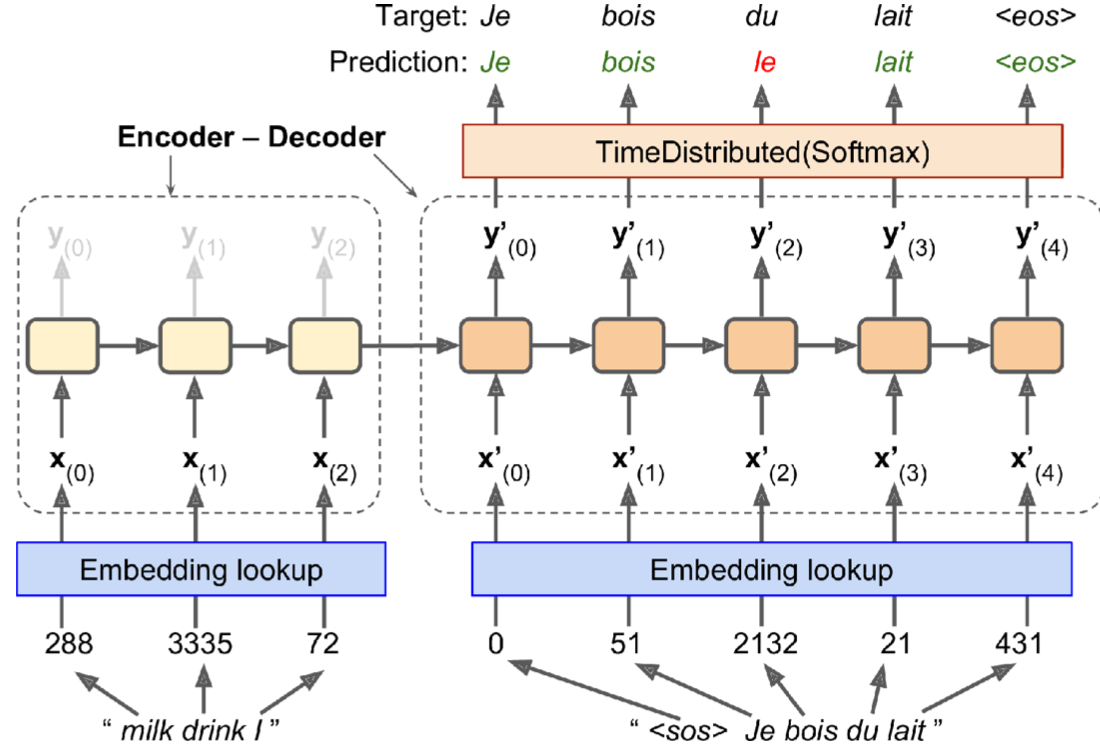

### Note that at inference time (after training), you will not have the target sentence to feed to the decoder. Instead, simply feed the decoder the word that it output at the previous step,  

Feeding the previous output word as input at inference time
  
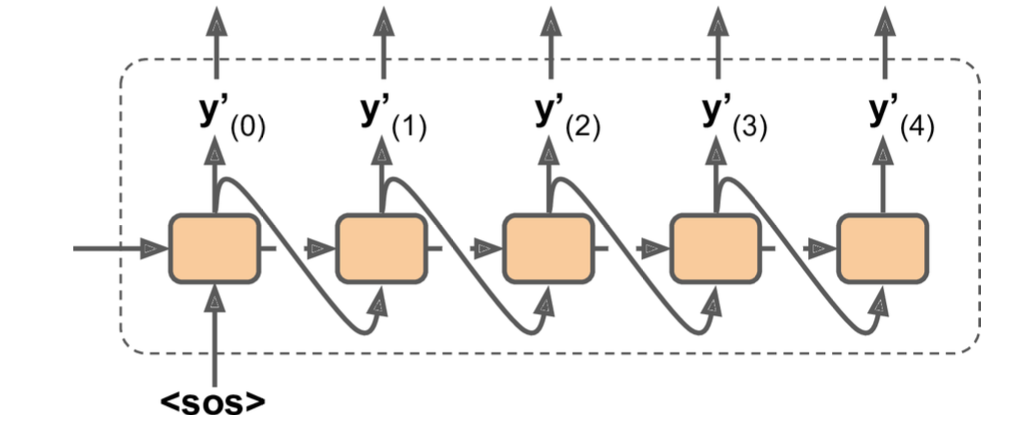  
  
ScheduledEmbeddingTrainingSampler  
 - andomly choose between the target or the actual output, with a probability that you can gradually change during training.  
 - 2015 https://arxiv.org/abs/1506.03099

In [2]:
tf.random.set_seed(42)

In [3]:
vocab_size = 100
embed_size = 10

pip install tensorflow-addons

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa

In [10]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
# return_state=True when creating the LSTM layer
# so that we can get its final hidden state and pass it to the decoder.
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]
# returns two hidden states (short term and long term)

sampler = tfa.seq2seq.sampler.TrainingSampler()
# TrainingSampler is one of several samplers available in TensorFlow Addons:   
# role is to tell the decoder at each step what it should pretend the previous output was.

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                output_layer=output_layer)

final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)
# tf.nn.sam pled_softmax_loss() function for this during training and use the normal softmax 
# function at inference time (sampled softmax cannot be used at inference time because it requires knowing the target).

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

TypeError: in user code:

    /Users/j/handsonml/my_env/lib/python3.7/site-packages/tensorflow_addons/seq2seq/decoder.py:163 call  *
        self,
    /Users/j/handsonml/my_env/lib/python3.7/site-packages/typeguard/__init__.py:261 wrapper  *
        check_argument_types(memo)
    /Users/j/handsonml/my_env/lib/python3.7/site-packages/typeguard/__init__.py:698 check_argument_types  *
        check_type(description, value, expected_type, memo)
    /Users/j/handsonml/my_env/lib/python3.7/site-packages/typeguard/__init__.py:593 check_type  *
        checker_func(argname, value, expected_type, memo)
    /Users/j/handsonml/my_env/lib/python3.7/site-packages/typeguard/__init__.py:416 check_union  *
        raise TypeError('type of {} must be one of ({}); got {} instead'.

    TypeError: type of argument "training" must be one of (bool, NoneType); got tensorflow.python.framework.ops.Tensor instead


In [11]:
# sequence_length, initial_state, 
sequence_lengths, encoder_state

(<tf.Tensor 'input_9:0' shape=(None,) dtype=int32>,
 [<tf.Tensor 'lstm_2/Identity_1:0' shape=(None, 512) dtype=float32>,
  <tf.Tensor 'lstm_2/Identity_2:0' shape=(None, 512) dtype=float32>])

In [12]:
sequence_lengths, encoder_inputs, decoder_inputs 

(<tf.Tensor 'input_9:0' shape=(None,) dtype=int32>,
 <tf.Tensor 'input_7:0' shape=(None, None) dtype=int32>,
 <tf.Tensor 'input_8:0' shape=(None, None) dtype=int32>)

In [13]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

NameError: name 'model' is not defined

In [14]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

NameError: name 'model' is not defined

### Bidirectional Recurrent Layers  
 - A each time step, a regular recurrent layer only looks at past and present inputs before generating its output.
  - “causal,” meaning it cannot look into the future  
 - This type of RNN makes sense when forecasting time series,  
 - To implement this, run two recurrent layers on the same inputs, one reading the words from `left to right` and the other reading them from `right to left`.   
 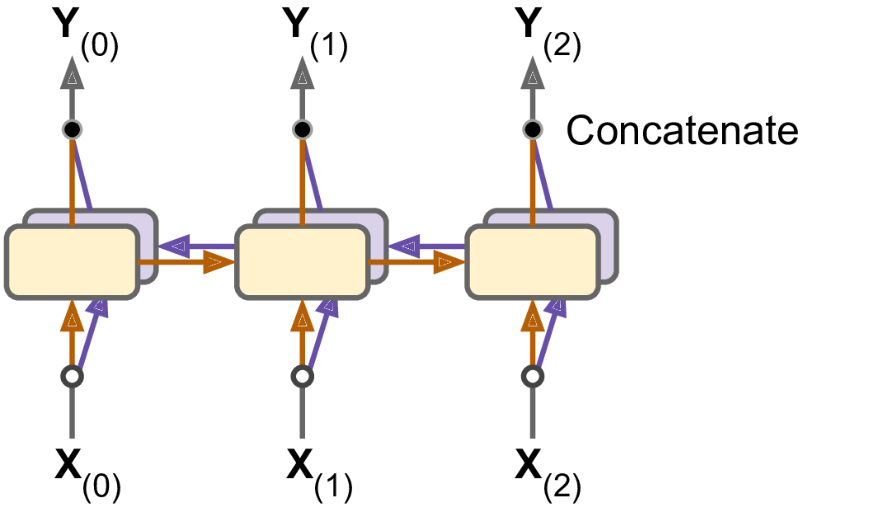

The Bidirectional layer will create a clone of the GRU layer (but in the reverse direction), and it will run both and concatenate their outputs.   
 - So although the GRU layer has 10 units,   
 - the Bidirectional layer will output 20 values per time step.

In [15]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Beam Search  
How can we give the model a chance to go back and fix mistakes it made earlier?  
 -  it keeps track of a short list of the k most promising sentences  
 -  at each decoder step it tries to extend them by one word, keeping only the k most likely sentences.  
 - parameter k is called the beam width.  
 
 <br>  
 first decoder step(beam width of 3)  
  - Suppose the top three words are “How” (75% estimated probability), “What” (3%), and “You” (1%).  
  - Next, we create three copies of our model and use them to find the next word for each sentence.  
  - first model will try to find the next word in the sentence “How,” and perhaps it will output a probability of 36% for the word “will,” 32% for the word “are,” 16% for the word “do,” and so on.  
  - The second model will try to complete the sentence “What”; it might output a conditional probability of 50% for the word “are,” and so on.  
  - After computing the probabilities of all 30,000 two-word sentences, we keep only the top 3. Perhaps they all start with the word “How”: “How will” (27%), “How are” (24%), and “How do” (12%).   
  - Then we repeat the same process  
  - “How are you” (10%), “How do you” (8%), and “How will you” (2%).  
  - next step we may get “How do you do” (7%), “How are you <eos>” (6%), and “How are you doing” (3%)

In [17]:
beam_width = 10
decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(
    cell=decoder_cell, beam_width=beam_width, output_layer=output_layer)
# first create a BeamSearchDecoder, which wraps all the decoder clones (in this case 10 clones)

decoder_initial_state = tfa.seq2seq.beam_search_decoder.tile_batch(
    encoder_state, multiplier=beam_width) 
# Then we create one copy of the encoder’s final state for each decoder clone,

outputs, _, _ = decoder(
    embedding_decoder, start_tokens=start_tokens, end_token=end_token, 
    initial_state=decoder_initial_state)
# and we pass these states to the decoder, along with the start and end tokens.


NameError: name 'embedding_decoder' is not defined

### Attention Mechanisms  
Unfortunately, this model will be really bad at translating long sentences.   
 - Once again, the problem comes from the limited short-term memory of RNNs.   

Attention mechanisms are the game-changing innovation that addressed this problem    
***
2014 https://arxiv.org/abs/1409.0473    
***
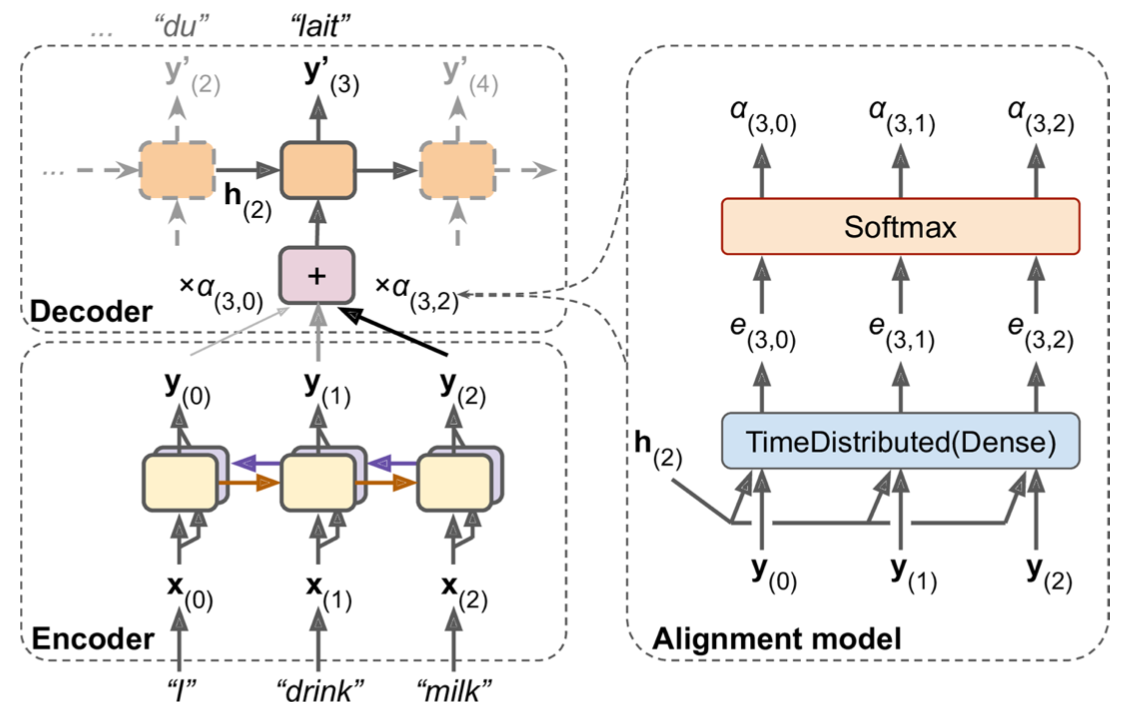

2015 https://arxiv.org/abs/1508.04025  
***  
goal of the attention mechanism is to measure the similarity between one of the encoder’s outputs and the decoder’s previous hidden state,  
 - authors proposed to simply compute the dot product (see Chapter 4) of these two vectors,  
 - both vectors must have the same dimensionality 
 - 

In [18]:
# Luong attention to an Encoder–Decoder model using TensorFlow Addons:
attention_mechanism = tfa.seq2seq.attention_wrapper.LuongAttention( units, encoder_state, memory_sequence_length=encoder_sequence_length)
attention_decoder_cell = tfa.seq2seq.attention_wrapper.AttentionWrapper( decoder_cell, attention_mechanism, attention_layer_size=n_units)

NameError: name 'units' is not defined

### Visual Attention  
generating image captions using visual attention:  
 - convolutional neural network first processes the image and outputs some feature maps, then a decoder RNN equipped with an attention mechanism generates the caption, one word at a time.  

#### Explainability  
 One extra benefit of attention mechanisms is that they make it easier to understand what led the model to produce its output  

<font color=green>In some applications, explainability is not just a tool to debug a model; it can be a legal requirement (think of a system deciding whether or not it should grant you a loan)</font>.

### Attention Is All You Need: The Transformer Architecture   
***
2017 https://arxiv.org/abs/1706.03762  
***  
just attention mechanisms + embedding layers, dense layers, normalization layers, and a few other bits and pieces.  
 - much faster to train and easier to parallelize,  
 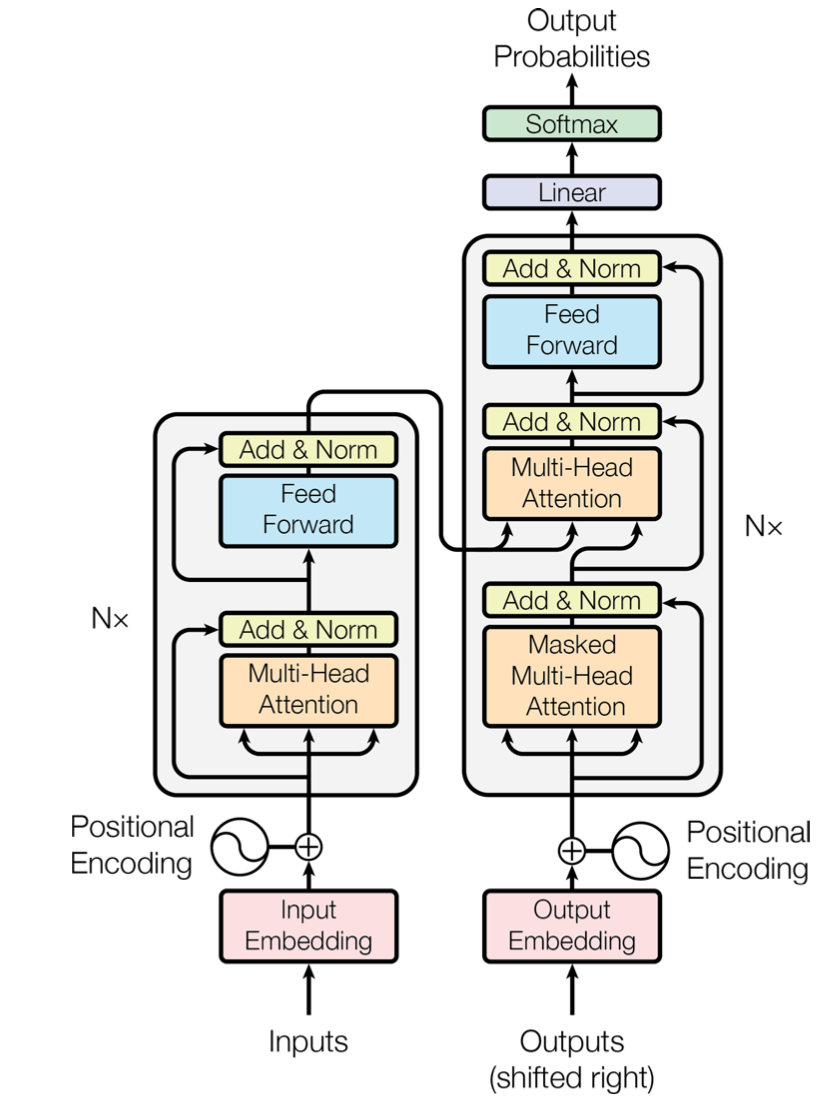

#### lefthand part is the encoder  
  - it takes as input a batch of sentences represented as sequences of word IDs (the input shape is `[batch size, max input sentence length]`)  
  - encodes each word into a 512-dimensional repreentation (so the encoder’s output shape is `[batch size, max input sentence length, 512]`).  
  - encoder is stacked N times (in the paper, N = 6).

  
#### The righthand part is the decoder.  
 - During training, 
  - it takes the target sentence as input (also represented as a sequence of word IDs),  
  - shifted one time step to the right (i.e., a start-of-sequence token is inserted at the beginning)  
  - It also receives the outputs of the encoder (i.e., the arrows coming from the left side)  
  - top part of the decoder is also stacked N times,  
  - encoder stack’s final outputs are fed to the decoder at each of these N levels.  
  - decoder outputs a probability for each possible next word.  
  - at each time step (its output shape is `[batch size, max output sentence length, vocabulary length]`)  
 
#### During inference  
 - decoder cannot be fed targets   
 - so we feed it the previously output words (starting with a start-of-sequence token)  
 - predicting one more word at every round (which is fed to the decoder at the next round, until the end-of-sequence token is output).  

<br>
All of these layers are time-distributed,
 - two embedding layers,   
 - 5 × N skip connections,   
 - each of them followed by a layer normalization layer,   
 - 2 × N “Feed Forward” modules that are composed of two dense layers each (the first one using the ReLU activation function, the second with no activation function),   
 - finally the output layer is a dense layer using the softmax activation function.  

<br>  
“They welcomed the Queen of the United Kingdom”
#### encoder’s Multi-Head Attention layer   
 - encodes each word’s relationship with every other word in the same sentence  
 
#### decoder’s Masked Multi-Head Attention layer   
 - does the same thing, but each word is only allowed to attend to words located before it  
 -  decoder’s upper Multi-Head Attention layer is where the decoder pays attention to the words in the input sentence  
  - decoder will probably pay close attention to the word “Queen” in the input sentence when it is about to output this word’s translation.  
  
####  positional embeddings  
 - simply dense vectors (much like word embeddings)  
 - that represent the position of a word in the sentence.  
 - n(th) positional embedding is added to the word embedding of the n(th) word in each sentence.

### Positional Encoding  
 - A positional embedding is a dense vector that encodes the position of a word within a sentence:   
  - the $i^{th}$ position embedding is simply added to the word embedding of the $i^{th}$ word in the sentence.   
  
 - positional embeddings can be learned by the model, but in the paper the authors `preferred to use fixed positional embeddings`, defined using the sine and cosine functions of different frequencies

In [71]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [72]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

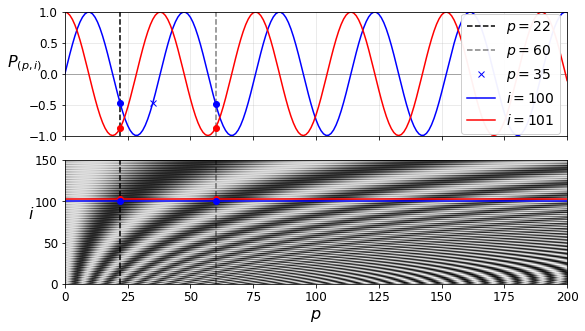

In [73]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

In [74]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention):

In [75]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [76]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [77]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])

# Exercise solutions  
***  
***

## 1. to 7.

See Appendix A.

## 8.
_Exercise:_ Embedded Reber grammars _were used by Hochreiter and Schmidhuber in [their paper](https://homl.info/93) about LSTMs. They are artificial grammars that produce strings such as "BPBTSXXVPSEPE." Check out Jenny Orr's [nice introduction](https://homl.info/108) to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr's page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don't._

First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [78]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Let's generate a few strings based on the default Reber grammar:

In [79]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Looks good. Now let's generate a few strings based on the embedded Reber grammar:

In [80]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [81]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Let's look at a few corrupted strings:

In [82]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

We cannot feed strings directly to an RNN, so we need to encode them somehow. One option would be to one-hot encode each character. Another option is to use embeddings. Let's go for the second option (but since there are just a handful of characters, one-hot encoding would probably be a good option as well). For embeddings to work, we need to convert each string into a sequence of character IDs. Let's write a function for that, using each character's index in the string of possible characters "BEPSTVX":

In [83]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [POSSIBLE_CHARS.index(c) for c in s]

In [84]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

We can now generate the dataset, with 50% good strings, and 50% bad strings:

In [85]:
def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [86]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

Let's take a look at the first training sequence:

In [87]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

What classes does it belong to?

In [88]:
y_train[0]

array([1.])

Perfect! We are ready to create the RNN to identify good strings. We build a simple sequence binary classifier:

In [89]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20


/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


120278/10000 [========================================================================================================================================================================================================================================================================================================================================================================] - 5s 42us/sample - loss: 0.6847 - accuracy: 0.5138 - val_loss: 8.1518 - val_accuracy: 0.6115
Epoch 2/20
120278/10000 [========================================================================================================================================================================================================================================================================================================================================================================] - 3s 28us/sample - loss: 0.6524 - accuracy: 0.5571 - val_loss: 7.9259 - val_accuracy: 0.6085
Epoch 3/20
120278/10000 [==========================

Now let's test our RNN on two tricky strings: the first one is bad while the second one is good. They only differ by the second to last character. If the RNN gets this right, it shows that it managed to notice the pattern that the second letter should always be equal to the second to last letter. That requires a fairly long short-term memory (which is the reason why we used a GRU cell).

In [90]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))


Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.40%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.96%


Ta-da! It worked fine. The RNN found the correct answers with very high confidence. :)

## 9.
_Exercise: Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from "April 22, 2019" to "2019-04-22")._

Let's start by creating the dataset. We will use random days between 1000-01-01 and 9999-12-31:

In [91]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

Here are a few random dates, displayed in both the input format and the target format:

In [92]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


Let's get the list of all possible characters in the inputs:

In [93]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS)))) + "01234567890, "
INPUT_CHARS

'ADFJMNOSabceghilmnoprstuvy01234567890, '

And here's the list of possible characters in the outputs:

In [94]:
OUTPUT_CHARS = "0123456789-"

Let's write a function to convert a string to a list of character IDs, as we did in the previous exercise:

In [95]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [96]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[7, 11, 19, 22, 11, 16, 9, 11, 20, 38, 28, 26, 37, 38, 33, 26, 33, 31]

In [97]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [98]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [99]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [100]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

### First version: a very basic seq2seq model

Let's first try the simplest possible model: we feed in the input sequence, which first goes through the encoder (an embedding layer followed by a single LSTM layer), which outputs a vector, then it goes through a decoder (a single LSTM layer, followed by a dense output layer), which outputs a sequence of vectors, each representing the estimated probabilities for all possible output character.

Since the decoder expects a sequence as input, we repeat the vector (which is output by the decoder) as many times as the longest possible output sequence.

In [101]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 6s 18ms/step - loss: 1.8111 - accuracy: 0.3533 - val_loss: 1.3581 - val_accuracy: 0.4965
Epoch 2/20
313/313 [==============================] - 5s 15ms/step - loss: 1.3518 - accuracy: 0.5103 - val_loss: 1.1915 - val_accuracy: 0.5694
Epoch 3/20
313/313 [==============================] - 5s 15ms/step - loss: 1.1706 - accuracy: 0.5908 - val_loss: 0.9983 - val_accuracy: 0.6398
Epoch 4/20
313/313 [==============================] - 5s 15ms/step - loss: 0.9158 - accuracy: 0.6686 - val_loss: 0.8012 - val_accuracy: 0.6987
Epoch 5/20
313/313 [==============================] - 5s 15ms/step - loss: 0.7058 - accuracy: 0.7308 - val_loss: 0.6224 - val_accuracy: 0.7599
Epoch 6/20
313/313 [==============================] - 5s 15ms/step - loss: 0.7756 - accuracy: 0.7203 - val_loss: 0.6541 - val_accuracy: 0.7599
Epoch 7/20
313/313 [==============================] - 5s 16ms/step - loss: 0.5379 - accuracy: 0.8034 - val_loss: 0.4174 - val_accuracy: 0.8440

Looks great, we reach 100% validation accuracy! Let's use the model to make some predictions. We will need to be able to convert a sequence of character IDs to a readable string:

In [102]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

Now we can use the model to convert some dates

In [103]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [104]:
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
2009-09-17
1789-07-14


Perfect! :)

However, since the model was only trained on input strings of length 18 (which is the length of the longest date), it does not perform well if we try to use it to make predictions on shorter sequences:

In [105]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [106]:
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2020-01-02
1789-02-14


Oops! We need to ensure that we always pass sequences of the same length as during training, using padding if necessary. Let's write a little helper function for that:

In [107]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = model.predict_classes(X)
    return ids_to_date_strs(ids)

In [108]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

['2020-05-02', '1789-07-14']

Cool! Granted, there are certainly much easier ways to write a date conversion tool (e.g., using regular expressions or even basic string manipulation), but you have to admit that using neural networks is way cooler. ;-)

However, real-life sequence-to-sequence problems will usually be harder, so for the sake of completeness, let's build a more powerful model.

### Second version: feeding the shifted targets to the decoder (teacher forcing)

Instead of feeding the decoder a simple repetition of the encoder's output vector, we can feed it the target sequence, shifted by one time step to the right. This way, at each time step the decoder will know what the previous target character was. This should help is tackle more complex sequence-to-sequence problems.

Since the first output character of each target sequence has no previous character, we will need a new token to represent the start-of-sequence (sos).

During inference, we won't know the target, so what will we feed the decoder? We can just predict one character at a time, starting with an sos token, then feeding the decoder all the characters that were predicted so far (we will look at this in more details later in this notebook).

But if the decoder's LSTM expects to get the previous target as input at each step, how shall we pass it it the vector output by the encoder? Well, one option is to ignore the output vector, and instead use the encoder's LSTM state as the initial state of the decoder's LSTM (which requires that encoder's LSTM must have the same number of units as the decoder's LSTM).

Now let's create the decoder's inputs (for training, validation and testing). The sos token will be represented using the last possible output character's ID + 1.

In [109]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

Let's take a look at the decoder's training inputs:

In [110]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

Now let's build the model. It's not a simple sequential model anymore, so let's use the functional API:

In [111]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 5s 17ms/step - loss: 1.6898 - accuracy: 0.3714 - val_loss: 1.4141 - val_accuracy: 0.4603
Epoch 2/10
313/313 [==============================] - 5s 15ms/step - loss: 1.2118 - accuracy: 0.5541 - val_loss: 0.9360 - val_accuracy: 0.6653
Epoch 3/10
313/313 [==============================] - 5s 15ms/step - loss: 0.6399 - accuracy: 0.7766 - val_loss: 0.4054 - val_accuracy: 0.8631
Epoch 4/10
313/313 [==============================] - 5s 15ms/step - loss: 0.2207 - accuracy: 0.9463 - val_loss: 0.1069 - val_accuracy: 0.9869
Epoch 5/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0805 - accuracy: 0.9910 - val_loss: 0.0445 - val_accuracy: 0.9976
Epoch 6/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0297 - accuracy: 0.9993 - val_loss: 0.0237 - val_accuracy: 0.9992
Epoch 7/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0743 - accuracy: 0.9857 - val_loss: 0.0702 - val_accuracy: 0.9889

This model also reaches 100% validation accuracy, but it does so even faster.

Let's once again use the model to make some predictions. This time we need to predict characters one by one.

In [112]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [113]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Works fine! :)

### Third version: using TF-Addons's seq2seq implementation

Let's build exactly the same model, but using TF-Addon's seq2seq API. The implementation below is almost very similar to the TFA example higher in this notebook, except without the model input to specify the output sequence length, for simplicity (but you can easily add it back in if you need it for your projects, when the output sequences have very different lengths).

In [114]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 5s 17ms/step - loss: 1.6757 - accuracy: 0.3683 - val_loss: 1.4602 - val_accuracy: 0.4214
Epoch 2/15
313/313 [==============================] - 5s 15ms/step - loss: 1.3873 - accuracy: 0.4566 - val_loss: 1.2904 - val_accuracy: 0.4957
Epoch 3/15
313/313 [==============================] - 5s 15ms/step - loss: 1.0471 - accuracy: 0.6109 - val_loss: 0.7737 - val_accuracy: 0.7276
Epoch 4/15
313/313 [==============================] - 5s 15ms/step - loss: 0.5056 - accuracy: 0.8296 - val_loss: 0.2695 - val_accuracy: 0.9305
Epoch 5/15
313/313 [==============================] - 5s 15ms/step - loss: 0.1677 - accuracy: 0.9657 - val_loss: 0.0870 - val_accuracy: 0.9912
Epoch 6/15
313/313 [==============================] - 5s 15ms/step - loss: 0.1007 - accuracy: 0.9850 - val_loss: 0.0492 - val_accuracy: 0.9975
Epoch 7/15
313/313 [==============================] - 5s 15ms/step - loss: 0.0308 - accuracy: 0.9993 - val_loss: 0.0228 - val_accuracy: 0.9996

And once again, 100% validation accuracy! To use the model, we can just reuse the `predict_date_strs()` function:

In [115]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

However, there's a much more efficient way to perform inference. Until now, during inference, we've run the model once for each new character. Instead, we can create a new decoder, based on the previously trained layers, but using a `GreedyEmbeddingSampler` instead of a `TrainingSampler`.

At each time step, the `GreedyEmbeddingSampler` will compute the argmax of the decoder's outputs, and run the resulting token IDs through the decoder's embedding layer. Then it will feed the resulting embeddings to the decoder's LSTM cell at the next time step. This way, we only need to run the decoder once to get the full prediction.

In [116]:
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

A few notes:
* The `GreedyEmbeddingSampler` needs the `start_tokens` (a vector containing the start-of-sequence ID for each decoder sequence), and the `end_token` (the decoder will stop decoding a sequence once the model outputs this token).
* We must set `maximum_iterations` when creating the `BasicDecoder`, or else it may run into an infinite loop (if the model never outputs the end token for at least one of the sequences). This would force you would to restart the Jupyter kernel.
* The decoder inputs are not needed anymore, since all the decoder inputs are generated dynamically based on the outputs from the previous time step.
* The model's outputs are `final_outputs.sample_id` instead of the softmax of `final_outputs.rnn_outputs`. This allows us to directly get the argmax of the model's outputs. If you prefer to have access to the logits, you can replace `final_outputs.sample_id` with `final_outputs.rnn_outputs`.

Now we can write a simple function that uses the model to perform the date format conversion:

In [117]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [118]:
fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Let's check that it really is faster:

In [119]:
%timeit predict_date_strs(["July 14, 1789", "May 01, 2020"])

199 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [120]:
%timeit fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

18.3 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's more than a 10x speedup! And it would be even more if we were handling longer sequences.

### Fourth version: using TF-Addons's seq2seq implementation with a scheduled sampler

**Warning**: due to a TF bug, this version only works using TensorFlow 2.2.

When we trained the previous model, at each time step _t_ we gave the model the target token for time step _t_ - 1. However, at inference time, the model did not get the previous target at each time step. Instead, it got the previous prediction. So there is a discrepancy between training and inference, which may lead to disappointing performance. To alleviate this, we can gradually replace the targets with the predictions, during training. For this, we just need to replace the `TrainingSampler` with a `ScheduledEmbeddingTrainingSampler`, and use a Keras callback to gradually increase the `sampling_probability` (i.e., the probability that the decoder will use the prediction from the previous time step rather than the target for the previous time step).

In [121]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 20
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(
    sampling_probability=0.,
    embedding_fn=decoder_embedding_layer)
# we must set the sampling_probability after creating the sampler
# (see https://github.com/tensorflow/addons/pull/1714)
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)

sampling_probability_cb = keras.callbacks.LambdaCallback(
    on_epoch_begin=update_sampling_probability)
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
                    validation_data=([X_valid, X_valid_decoder], Y_valid),
                    callbacks=[sampling_probability_cb])

Epoch 1/20


/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


313/313 [==============================] - 6s 19ms/step - loss: 1.6759 - accuracy: 0.3681 - val_loss: 1.4611 - val_accuracy: 0.4198
Epoch 2/20
313/313 [==============================] - 5s 17ms/step - loss: 1.3872 - accuracy: 0.4583 - val_loss: 1.2827 - val_accuracy: 0.5021
Epoch 3/20
313/313 [==============================] - 5s 17ms/step - loss: 1.0425 - accuracy: 0.6152 - val_loss: 0.8165 - val_accuracy: 0.7000
Epoch 4/20
313/313 [==============================] - 5s 17ms/step - loss: 0.6353 - accuracy: 0.7673 - val_loss: 0.4365 - val_accuracy: 0.8464
Epoch 5/20
313/313 [==============================] - 5s 17ms/step - loss: 0.3764 - accuracy: 0.8765 - val_loss: 0.2795 - val_accuracy: 0.9166
Epoch 6/20
313/313 [==============================] - 5s 17ms/step - loss: 0.2506 - accuracy: 0.9269 - val_loss: 0.1805 - val_accuracy: 0.9489
Epoch 7/20
313/313 [==============================] - 5s 17ms/step - loss: 0.1427 - accuracy: 0.9625 - val_loss: 0.1115 - val_accuracy: 0.9718
Epoch 8/20

Not quite 100% validation accuracy, but close enough!

For inference, we could do the exact same thing as earlier, using a `GreedyEmbeddingSampler`. However, just for the sake of completeness, let's use a `SampleEmbeddingSampler` instead. It's almost the same thing, except that instead of using the argmax of the model's output to find the token ID, it treats the outputs as logits and uses them to sample a token ID randomly. This can be useful when you want to generate text. The `softmax_temperature` argument serves the 
same purpose as when we generated Shakespeare-like text (the higher this argument, the more random the generated text will be).

In [122]:
softmax_temperature = tf.Variable(1.)

inference_sampler = tfa.seq2seq.sampler.SampleEmbeddingSampler(
    embedding_fn=decoder_embedding_layer,
    softmax_temperature=softmax_temperature)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [123]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [124]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Dates look good at room temperature. Now let's heat things up a bit:

In [125]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"],
                           temperature=5.)

['2289607-12', '9272-03-01']

Oops, the dates are overcooked, now. Let's call them "creative" dates.

### Fifth version: using TFA seq2seq, the Keras subclassing API and attention mechanisms

The sequences in this problem are pretty short, but if we wanted to tackle longer sequences, we would probably have to use attention mechanisms. While it's possible to code our own implementation, it's simpler and more efficient to use TF-Addons's implementation instead. Let's do that now, this time using Keras' subclassing API.

**Warning**: due to a TensorFlow bug (see [this issue](https://github.com/tensorflow/addons/issues/1153) for details), the `get_initial_state()` method fails in eager mode, so for now we have to use the subclassing API, as Keras automatically calls `tf.function()` on the `call()` method (so it runs in graph mode).

In this implementation, we've reverted back to using the `TrainingSampler`, for simplicity (but you can easily tweak it to use a `ScheduledEmbeddingTrainingSampler` instead). We also use a `GreedyEmbeddingSampler` during inference, so this class is pretty easy to use:

In [126]:
class DateTranslation(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32,
                 decoder_embedding_size=32, **kwargs):
        super().__init__(**kwargs)
        self.encoder_embedding = keras.layers.Embedding(
            input_dim=len(INPUT_CHARS) + 1,
            output_dim=encoder_embedding_size)
        self.encoder = keras.layers.LSTM(units,
                                         return_sequences=True,
                                         return_state=True)
        self.decoder_embedding = keras.layers.Embedding(
            input_dim=len(OUTPUT_CHARS) + 2,
            output_dim=decoder_embedding_size)
        self.attention = tfa.seq2seq.LuongAttention(units)
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(
            cell=decoder_inner_cell,
            attention_mechanism=self.attention)
        output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
        self.decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.TrainingSampler(),
            output_layer=output_layer)
        self.inference_decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(
                embedding_fn=self.decoder_embedding),
            output_layer=output_layer,
            maximum_iterations=max_output_length)

    def call(self, inputs, training=None):
        encoder_input, decoder_input = inputs
        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(
            encoder_embeddings,
            training=training)
        encoder_state = [encoder_state_h, encoder_state_c]

        self.attention(encoder_outputs,
                       setup_memory=True)
        
        decoder_embeddings = self.decoder_embedding(decoder_input)

        decoder_initial_state = self.decoder_cell.get_initial_state(
            decoder_embeddings)
        decoder_initial_state = decoder_initial_state.clone(
            cell_state=encoder_state)
        
        if training:
            decoder_outputs, _, _ = self.decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                training=training)
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
            decoder_outputs, _, _ = self.inference_decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                start_tokens=start_tokens,
                end_token=0)

        return tf.nn.softmax(decoder_outputs.rnn_output)

In [127]:
np.random.seed(42)
tf.random.set_seed(42)

model = DateTranslation()
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=25,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/25
313/313 [==============================] - 7s 21ms/step - loss: 2.1549 - accuracy: 0.2295 - val_loss: 2.1450 - val_accuracy: 0.2239
Epoch 2/25
313/313 [==============================] - 6s 19ms/step - loss: 1.8147 - accuracy: 0.3492 - val_loss: 1.4931 - val_accuracy: 0.4476
Epoch 3/25
313/313 [==============================] - 6s 18ms/step - loss: 1.3585 - accuracy: 0.4909 - val_loss: 1.3168 - val_accuracy: 0.5100
Epoch 4/25
313/313 [==============================] - 6s 18ms/step - loss: 1.2787 - accuracy: 0.5293 - val_loss: 1.1767 - val_accuracy: 0.5624
Epoch 5/25
313/313 [==============================] - 6s 18ms/step - loss: 1.1236 - accuracy: 0.5776 - val_loss: 1.0769 - val_accuracy: 0.5907
Epoch 6/25
313/313 [==============================] - 6s 18ms/step - loss: 1.0369 - accuracy: 0.6073 - val_loss: 1.0159 - val_accuracy: 0.6199
Epoch 7/25
313/313 [==============================] - 6s 18ms/step - loss: 0.9752 - accuracy: 0.6295 - val_loss: 0.9723 - val_accuracy: 0.6346

Not quite 100% validation accuracy, but close. It took a bit longer to converge this time, but there were also more parameters and more computations per iteration. And we did not use a scheduled sampler.

To use the model, we can write yet another little function:

In [128]:
def fast_predict_date_strs_v2(date_strs):
    X = prepare_date_strs_padded(date_strs)
    X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
    Y_probas = model.predict([X, X_decoder])
    Y_pred = tf.argmax(Y_probas, axis=-1)
    return ids_to_date_strs(Y_pred)

In [129]:
fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

There are still a few interesting features from TF-Addons that you may want to look at:
* Using a `BeamSearchDecoder` rather than a `BasicDecoder` for inference. Instead of outputing the character with the highest probability, this decoder keeps track of the several candidates, and keeps only the most likely sequences of candidates (see chapter 16 in the book for more details).
* Setting masks or specifying `sequence_length` if the input or target sequences may have very different lengths.
* Using a `ScheduledOutputTrainingSampler`, which gives you more flexibility than the `ScheduledEmbeddingTrainingSampler` to decide how to feed the output at time _t_ to the cell at time _t_+1. By default it feeds the outputs directly to cell, without computing the argmax ID and passing it through an embedding layer. Alternatively, you specify a `next_inputs_fn` function that will be used to convert the cell outputs to inputs at the next step.

## 10.
_Exercise: Go through TensorFlow's [Neural Machine Translation with Attention tutorial](https://homl.info/nmttuto)._

Simply open the Colab and follow its instructions. Alternatively, if you want a simpler example of using TF-Addons's seq2seq implementation for Neural Machine Translation (NMT), look at the solution to the previous question. The last model implementation will give you a simpler example of using TF-Addons to build an NMT model using attention mechanisms.

## 11.
_Exercise: Use one of the recent language models (e.g., GPT) to generate more convincing Shakespearean text._

The simplest way to use recent language models is to use the excellent [transformers library](https://huggingface.co/transformers/), open sourced by Hugging Face. It provides many modern neural net architectures (including BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet and more) for Natural Language Processing (NLP), including many pretrained models. It relies on either TensorFlow or PyTorch. Best of all: it's amazingly simple to use.

First, let's load a pretrained model. In this example, we will use OpenAI's GPT model, with an additional Language Model on top (just a linear layer with weights tied to the input embeddings). Let's import it and load the pretrained weights (this will download about 445MB of data to `~/.cache/torch/transformers`):

In [130]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

Next we will need a specialized tokenizer for this model. This one will try to use the [spaCy](https://spacy.io/) and [ftfy](https://pypi.org/project/ftfy/) libraries if they are installed, or else it will fall back to BERT's `BasicTokenizer` followed by Byte-Pair Encoding (which should be fine for most use cases).

In [131]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

Now let's use the tokenizer to tokenize and encode the prompt text:

In [132]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

Easy! Next, let's use the model to generate text after the prompt. We will generate 5 different sentences, each starting with the prompt text, followed by 40 additional tokens. For an explanation of what all the hyperparameters do, make sure to check out this great [blog post](https://huggingface.co/blog/how-to-generate) by Patrick von Platen (from Hugging Face). You can play around with the hyperparameters to try to obtain better results.

In [133]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239,   784,   645,  1184,   558,  1886,   688,  6437,
          240,   784,   645,   507,   641,  5486,   240,   600,   636,
          868,   604,   694,  2816,   485,  1894,   822,   481,  1491,
          600,   880,  6061,   239,   256, 40477,   256,   600,   635,
          538,   604,  1816,   525,   239],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   488,  1288,   989,   640, 16605,   239,   256, 40477,
          674,   481, 12744,  3912,   488,  3912,  5936,  2441,   811,
          488,  1040,   485,   754,  3952,   239, 40477,   481,  1375,
         1981,   833,  1210,   481, 17384,   488,   481,  3089,   488,
          481,  4815,   509,   498,  1424],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   980,   987,  1074, 13138,   240,   531,   501,   517,
          836

Now let's decode the generated sequences and print them:

In [134]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle. even if someone had given them permission, even if it were required, they would never have been allowed to live through the hell they've survived.'
'they couldn't have known that.
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle and these people are royalty.'
 then the mute prince and prince edward broke off and went to their rooms. 
 the talk passed again between the princes and the guards and the princess was of great
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle has its own highness, an alatte that waits to save you. in this kingdom your people must emulate the kings of the realm. in this kingdom your kin should be saved from this pit and
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle belongs to me

You can try more recent (and larger) models, such as GPT-2, CTRL, Transformer-XL or XLNet, which are all available as pretrained models in the transformers library, including variants with Language Models on top. The preprocessing steps vary slightly between models, so make sure to check out this [generation example](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py) from the transformers documentation (this example uses PyTorch, but it will work with very little tweaks, such as adding `TF` at the beginning of the model class name, removing the `.to()` method calls, and using `return_tensors="tf"` instead of `"pt"`.

Hope you enjoyed this chapter! :)